# Import Packages

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

# Defining Transformers

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

#Train and Test data

In [ ]:
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transform)

test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transform)

#Train and Test Dataloaders

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False, num_workers=0)

In [ ]:
len(train_loader), len(test_loader)

(3000, 500)

#Defining Neural Network

In [ ]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.fc1 = nn.Linear(784, 512) #LT for hidden layer 1
        self.fc2 = nn.Linear(512, 256) #LT for hidden layer 2
        self.out = nn.Linear(256, 10) #LT for output layer

        self.dropout = nn.Dropout(0.2) #shuts down neurons (20% chance) for all neurons to learn well

    #forward propagation, feeding in values to the NN layers
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

#Initializing Weights

In [ ]:
model = FNet()
def weight_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = (1.0 / np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model.apply(weight_init_normal)

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

#Defining Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()

#Training Phase, Backpropagation

In [ ]:
def trainNet(model, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) #Adam Optimizer: adapts learning rates per parameter

    epochs = 20  #no of iterations for minimising loss function
    loss_keeper = {'train': []} #stores value of loss at each iteration

    for epoch in range(epochs):
        train_loss = 0.0
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss / len(train_loader)

        # saving loss value at each iteration
        loss_keeper['train'].append(train_loss)

        print(f'\nEpoch : {epoch+1}\tTraining Loss : {train_loss}')

    return loss_keeper

#Loading Model from Lowest Validation Loss

In [ ]:
m_loss = trainNet(model, 0.001)


Epoch : 1	Training Loss : 0.22028753244360755

Epoch : 2	Training Loss : 0.11104199134088898

Epoch : 3	Training Loss : 0.08553067639598642

Epoch : 4	Training Loss : 0.06917065772182893

Epoch : 5	Training Loss : 0.0629732149122151

Epoch : 6	Training Loss : 0.05666120936894542

Epoch : 7	Training Loss : 0.05103056929087999

Epoch : 8	Training Loss : 0.046120450871101636

Epoch : 9	Training Loss : 0.04285900425337202

Epoch : 10	Training Loss : 0.042136451304393994

Epoch : 11	Training Loss : 0.04161190508954021

Epoch : 12	Training Loss : 0.03801290385533621

Epoch : 13	Training Loss : 0.03941344018835457

Epoch : 14	Training Loss : 0.036339472103681145

Epoch : 15	Training Loss : 0.035526262629276634

Epoch : 16	Training Loss : 0.03353379295297389

Epoch : 17	Training Loss : 0.03291918558952185

Epoch : 18	Training Loss : 0.03463988229788932

Epoch : 19	Training Loss : 0.032731925889879984

Epoch : 20	Training Loss : 0.032706457330299185


In [ ]:
m_loss

{'train': [0.22028753244360755,
  0.11104199134088898,
  0.08553067639598642,
  0.06917065772182893,
  0.0629732149122151,
  0.05666120936894542,
  0.05103056929087999,
  0.046120450871101636,
  0.04285900425337202,
  0.042136451304393994,
  0.04161190508954021,
  0.03801290385533621,
  0.03941344018835457,
  0.036339472103681145,
  0.035526262629276634,
  0.03353379295297389,
  0.03291918558952185,
  0.03463988229788932,
  0.032731925889879984,
  0.032706457330299185]}

In [ ]:
torch.save(model.state_dict(), 'FNet_model.pth')

#Testing Phase

In [ ]:
def test(model):
    correct = 0
    test_loss = 0
    class_correct = [0. for _ in range(10)]
    class_total = [0. for _ in range(10)]



    model.eval()

    #feeding test images into model
    for images, labels in test_loader:
        output = model(images)
        loss = criterion(output, labels)
        test_loss += loss.item()

        _, pred = torch.max(output, 1)
        correct_batch = pred.eq(labels)

        #updating no of correct and total test cases
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += correct_batch[i].item()
            class_total[label] += 1


    #average test loss
    test_loss = test_loss / len(test_loader)
    print(f'\nFor {type(model).__name__} :')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Correctly predicted per class : {class_correct}')
    print(f'Total predictions per class : {class_total}\n')

    #calculating %accuracy
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f"Test Accuracy of class {i}: {acc:.2f}% ({int(class_correct[i])} / {int(class_total[i])})")
        else:
            print(f"Test Accuracy of class {i}: N/A (no test samples)")

    overall_acc = 100. * sum(class_correct) / sum(class_total)
    print(f"\nOverall Test Accuracy: {overall_acc:.2f}% ({int(sum(class_correct))} / {int(sum(class_total))})")

    # Plot one batch
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    output = model(images)
    _, preds = torch.max(output, 1)
    images = images.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(f"{preds[idx].item()} ({labels[idx].item()})",
                     color="green" if preds[idx] == labels[idx] else "red")


    images, labels = next(dataiter)
    output = model(images)
    _, preds = torch.max(output, 1)
    images = images.numpy()

    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(f"{preds[idx].item()} ({labels[idx].item()})",
                    color="green" if preds[idx] == labels[idx] else "red")

Visualising a Test Batch with Results


For FNet :
Test Loss: 0.0916
Correctly predicted per class : [972.0, 1125.0, 1011.0, 986.0, 971.0, 876.0, 945.0, 1015.0, 954.0, 979.0]
Total predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0]

Test Accuracy of class 0: 99.18% (972 / 980)
Test Accuracy of class 1: 99.12% (1125 / 1135)
Test Accuracy of class 2: 97.97% (1011 / 1032)
Test Accuracy of class 3: 97.62% (986 / 1010)
Test Accuracy of class 4: 98.88% (971 / 982)
Test Accuracy of class 5: 98.21% (876 / 892)
Test Accuracy of class 6: 98.64% (945 / 958)
Test Accuracy of class 7: 98.74% (1015 / 1028)
Test Accuracy of class 8: 97.95% (954 / 974)
Test Accuracy of class 9: 97.03% (979 / 1009)

Overall Test Accuracy: 98.34% (9834 / 10000)


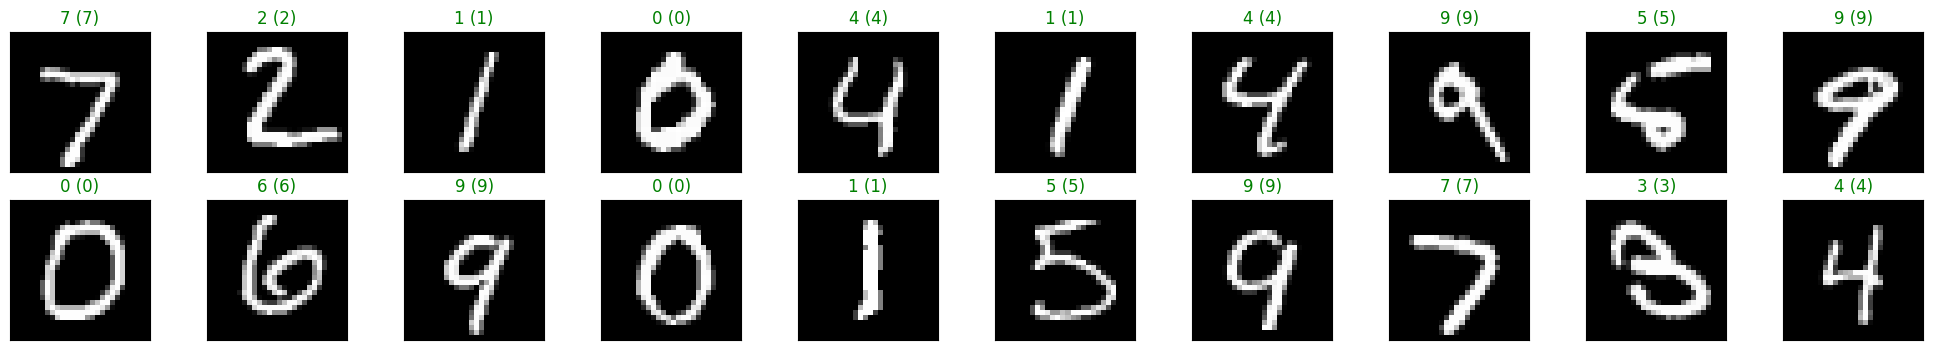

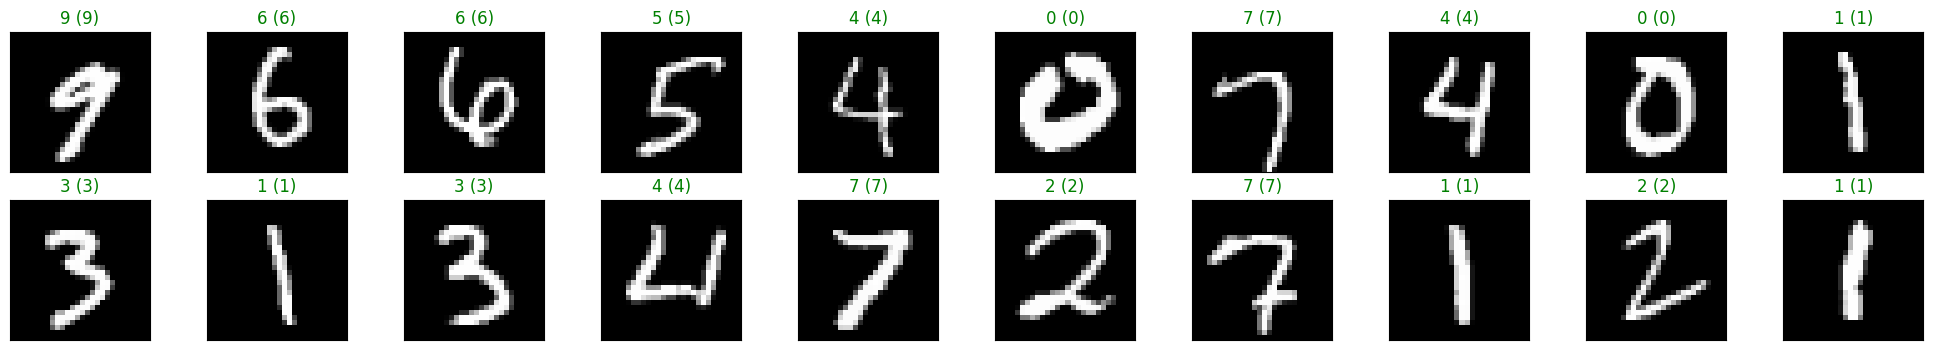

In [ ]:
test(model)